In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import gc
import random

from IPython import display as ipd
from tqdm import tqdm
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import RandomOverSampler

import optuna 
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-dec-2021/train.csv
/kaggle/input/tabular-playground-series-dec-2021/test.csv


0.8.1


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col != 'time':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def get_stats(df):
    stats = pd.DataFrame(index=df.columns, columns=['na_count', 'n_unique', 'type', 'memory_usage'])
    for col in df.columns:
        stats.loc[col] = [df[col].isna().sum(), df[col].nunique(dropna=False), df[col].dtypes, df[col].memory_usage(deep=True, index=False) / 1024**2]
    stats.loc['Overall'] = [stats['na_count'].sum(), stats['n_unique'].sum(), None, df.memory_usage(deep=True).sum() / 1024**2]
    return stats

def seeding(SEED, use_tf=False):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    if use_tf:
        tf.random.set_seed(SEED)
    print('seeding done!!!')

In [3]:
RANDOM_SEED = 42
DEBUG = False
TUNING = False

seeding(RANDOM_SEED)

train = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/test.csv')
submission = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv')

train = train.sample(frac=1.0)

target = train.Cover_Type
train.drop(['Id','Cover_Type'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# reduce memory footprint
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
gc.collect()

seeding done!!!
Mem. usage decreased to 270.84 Mb (83.9% reduction)
Mem. usage decreased to 60.08 Mb (85.4% reduction)


0

## Dealing with imbalanced targets

In [4]:
# map targets to match LGBM class reqs
def remap_target_classes(y):
    for i in range(1,8):
        y[y==i] = i-1
    return y

sampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_SEED)
X_sample, y_sample = sampler.fit_resample(train, target)

y_sample = remap_target_classes(y_sample)

del sampler
gc.collect()

# doublecheck class distribution
if DEBUG:
    y_sample.hist()

In [5]:
## to speed thing up - resample and reduce the size of train and target datasets
DEBUG_SAMPLE = 500000

if DEBUG:
    temp = pd.concat( [X_sample, y_sample], axis=1 )
    temp = temp[:DEBUG_SAMPLE]
    y = temp.Cover_Type
    X = temp.drop(['Cover_Type'], axis=1)
    del temp
else:
    ## full dataset takes too much time
    y = y_sample[:4000000]
    X = X_sample[:4000000]

In [6]:
#scaler = RobustScaler()
#X = scaler.fit_transform(X)
#test = scaler.transform(test)

## Tuning

In [7]:
LEARNING_RATE = 0.01
MAX_DEPTH = -1
NUM_LEAVES = 31
TOTAL_SPLITS = 3
NUM_BOOST_ROUND = 500
EARLY_STOPPING_ROUNDS = 20
VERBOSE_EVAL = 100
    

def objective(trial, X, y):
    
    param_grid = {
        'verbosity': -1,
        'num_class' : 7,
        'boosting_type': 'gbdt', 
        'objective': 'multiclass', 
        'metric': ['multi_logloss'],
        'n_estimators': trial.suggest_categorical('n_estimators', [2000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 1000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 512),      
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }    
        
    X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.25, random_state=RANDOM_SEED, shuffle=True)
    eval_results = {}  # to record eval results for plotting
    model = lgb.train(
        param_grid, valid_names=["train", "valid"], 
        train_set=lgb.Dataset(X_train, y_train ), 
        num_boost_round = NUM_BOOST_ROUND,
        valid_sets = [lgb.Dataset(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(VERBOSE_EVAL), 
                   lgb.early_stopping(EARLY_STOPPING_ROUNDS, False, True),
                   lgb.record_evaluation(eval_result=eval_results)],
    )
    
    yhat = np.argmax(model.predict(X_valid, workers=8), axis=1)
    score = f1_score(yhat, y_valid, average="macro")        
    return score

In [8]:
N_TRIALS = 100

if TUNING:
    study = optuna.create_study(direction='maximize')
    objective_func = lambda trial: objective(trial, X, y)
    study.optimize(objective_func, n_trials=N_TRIALS)  # number of iterations

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 

In [9]:
if TUNING:
    plot_optimization_history(study);

In [10]:
if TUNING:
    plot_param_importances(study);

## Model and train

In [11]:
def run_train(X, y, run_params, splits, num_boost_round, verbose_eval, early_stopping_rounds ):
    models = []
    oof_predicted = []
    eval_results = {}  # to record eval results for plotting
    folds = StratifiedKFold(n_splits=splits, random_state=RANDOM_SEED)
        
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print(f'Fold {fold_n+1} started')
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = lgb.train(
            run_params, valid_names=["train", "valid"], 
            train_set=lgb.Dataset(X_train, y_train ), 
            num_boost_round = num_boost_round,
            valid_sets = [lgb.Dataset(X_valid, y_valid)],
            callbacks=[lgb.log_evaluation(verbose_eval), 
                       lgb.early_stopping(early_stopping_rounds, False, True),
                       lgb.record_evaluation(eval_result=eval_results)],
        )
        yhat = model.predict(X_valid)
        score = accuracy_score(np.argmax(yhat, axis=1), y_valid)
        print(f"OOF accuracy score: {score}" )
        models.append(model)
    return models, oof_predicted, eval_results

In [12]:
run_params = {
    'verbose': -1,
    'num_class' : 7,
    'boosting_type': 'gbdt', 
    'objective': 'multiclass', 
    'metric': ['multi_logloss'],
    'n_estimators': 2000,
    'learning_rate': 0.08418575294220242,
    'num_leaves': 500,
    'max_depth': 10,
    'min_data_in_leaf': 300,
    'max_bin': 267,
    'lambda_l1': 0,
    'lambda_l2': 45,       
}

TOTAL_SPLITS = 5
NUM_BOOST_ROUND = 2000
EARLY_STOPPING_ROUNDS = 100
VERBOSE_EVAL = 200

models, oof_predicted, eval_results = run_train(X, y, run_params, TOTAL_SPLITS, NUM_BOOST_ROUND, VERBOSE_EVAL, EARLY_STOPPING_ROUNDS)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fold 1 started


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[200]	train's multi_logloss: 0.0854128
[400]	train's multi_logloss: 0.0815306
[600]	train's multi_logloss: 0.0807832
[800]	train's multi_logloss: 0.0806887
Early stopping, best iteration is:
[760]	train's multi_logloss: 0.0806574
OOF accuracy score: 0.9614675
Fold 2 started
Training until validation scores don't improve for 100 rounds
[200]	train's multi_logloss: 0.0861603
[400]	train's multi_logloss: 0.0822994
[600]	train's multi_logloss: 0.081621
[800]	train's multi_logloss: 0.0815813
Early stopping, best iteration is:
[715]	train's multi_logloss: 0.081555
OOF accuracy score: 0.9609975
Fold 3 started
Training until validation scores don't improve for 100 rounds
[200]	train's multi_logloss: 0.0855982
[400]	train's multi_logloss: 0.0816642
[600]	train's multi_logloss: 0.0809587
[800]	train's multi_logloss: 0.0808668
Early stopping, best iteration is:
[778]	train's multi_logloss: 0.0808556
OOF accuracy score: 0.96142625
Fold 

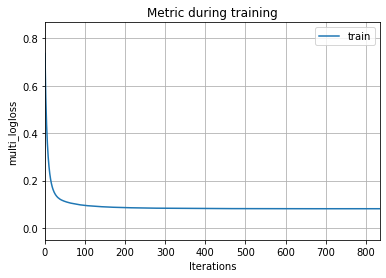

In [13]:
ax = lgb.plot_metric(eval_results, metric='multi_logloss')
plt.show()

## Predict

In [14]:
predicted = []
for model in models:
    predicted.append(np.argmax(model.predict(test), axis=1))
    
test_pred = np.mean(predicted, axis=0).astype(int)       
    
# map targets back 
test_pred[test_pred== 6] = 7
test_pred[test_pred== 5] = 6
test_pred[test_pred== 4] = 5
test_pred[test_pred== 3] = 4
test_pred[test_pred== 2] = 3
test_pred[test_pred== 1] = 2
test_pred[test_pred== 0] = 1

submission['Cover_Type'] = test_pred
submission.to_csv('submission.csv', index=False, float_format='%.6f')
submission.head(20)

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
5,4000005,3
6,4000006,2
7,4000007,1
8,4000008,2
9,4000009,3
